In [32]:
# load env
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["PINECODE_API_KEY"]=os.getenv("PINECODE_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.getenv("HUGGINGFACE_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]=os.getenv("LANGCHAIN_TRACING_V2")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [33]:
# pydantic model
from pydantic import BaseModel,Field

class TopicSelector(BaseModel):
    topic:str=Field(description="topic name")
    reason_for_selection:str=Field(description="topic selection reason")        



In [34]:
# model
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [35]:
# embeddings
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

384

In [36]:
from langchain_community.document_loaders import DirectoryLoader, TextLoader
# load document pages
loader=DirectoryLoader("./data",glob="./*.txt",loader_cls=TextLoader,show_progress=True)
pages = loader.load()
len(pages)

# split pages to chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

chunks=text_splitter.split_documents(pages);

len(chunks)


100%|██████████| 1/1 [00:00<00:00, 1422.28it/s]


55

In [37]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
# initialized the vector db
vector_store = Chroma(
    collection_name="usa-gdp-data",
    embedding_function=embeddings,
    # other params...
)

In [38]:
# save documents to vector db
vector_store.add_documents(chunks)

['b65adb5b-6cc4-4718-b682-1efa80da2188',
 '90fc25cb-9206-4e10-a1af-00aa65aa8d4e',
 '3a354b22-9b80-4812-914c-8b8d96c181c7',
 'f9febf5b-4e1b-437e-984b-b8b2d92d7882',
 '699335b1-8ce8-43ae-81f8-e619d84c98fc',
 'ad2cf712-f789-4dc5-bb49-cd9b60273f05',
 '00f74ca2-ed5a-42f6-bcb6-5e873e5af8b6',
 'fab11931-13c4-4abc-b39a-83f9a89bed6f',
 '6569cd87-7ce9-48c3-a91a-a4f3bdbb6212',
 'c4c44aca-4fe0-4108-8088-f02a4f39efe8',
 'd8c9009b-d280-4e42-b16b-25463026a56d',
 'a9b53db1-9935-4732-95c3-305c8ef85f77',
 'f543b52c-b876-424b-9670-8d012649eb90',
 'feeb951c-4771-4bc7-b3ab-3e0a488783b1',
 '545d75b1-f67f-41c5-a393-f206390a598a',
 '9c182ebb-77c8-4352-a7bc-b1266511ed81',
 '4f3161e8-5a62-4dee-bd6e-da5fa7f279e5',
 'fc5cd23e-f07c-4c6f-bf58-663304918111',
 'd38708fe-0598-491d-9c81-4bc5fe5ea4f9',
 '639ddafd-59cb-498e-adc9-a3e85e4c62b3',
 'cd267f4c-a799-4017-841d-9d54684b8228',
 '24a86cf1-e4fd-43d0-9d6a-5db631309303',
 'fedc88bd-001b-4b54-ad8b-f56e2a21d6fd',
 '8b9db5b9-ba1e-455d-8d09-dacc7dd047d6',
 '0063edc6-e2d4-

In [39]:
# db as retriever
data_retriever=vector_store.as_retriever(search_kwargs={"k":3})
data_retriever.invoke("industrial growth of usa?")

[Document(id='f0349411-7bbf-43da-b42c-7e3c668c1d12', metadata={'source': 'data/usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(id='7dff04e6-244c-4604-8c08-6df14cefb336', metadata={'source': 'data/usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(id='b65adb5b-6cc4-4718-b682-1efa80da2188', metadata={'source': 'data/usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy')]

In [40]:
# state
import operator
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]

In [41]:
# supervisor 
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
supervisor_parser=PydanticOutputParser(pydantic_object=TopicSelector)
def supervisor(state:AgentState):
    print("## supervisor ##")
    question=state["messages"][-1]
    print(f"## supervisor ## question : {question}")
    template="""
    Your task is to classify the given user query into one of the following categories: [USA,Not Related].
    Only respond with the category name and nothing else.
    
    User query: {question}
    {format_instructions}
    """
    
    prompt=PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": supervisor_parser.get_format_instructions()}
    )
    
    chain=prompt|model|supervisor_parser
    
    response=chain.invoke({"question":question})
    
    print(f"## supervisor ## response : {response}")
    
    return {"messages":[response.topic]}

In [42]:
# router 
def router(state:AgentState):
    print("## router ##")
    last_message=state["messages"][-1]
    print(f"## router ## last_message : {last_message}")
    if "rag" in last_message.lower():
        return "rag call"
    else :
        return "llm call"

In [43]:
# rag call
def rag_call(state:AgentState):
    print("## rag_call ##")
    question = state["messages"][0]
    print(f"## rag_call ## question : {question}")
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [44]:
# web search tavily
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_api_key=os.getenv("TAVILY_API_KEY")

tavily_tool=TavilySearchResults(travily_api_key=tavily_api_key)


In [45]:
from langchain_openai import ChatOpenAI
from langchain.tools import Tool
from langchain.agents import initialize_agent, AgentType
# llm call
def llm_call(state:AgentState):
    print("## llm_call ##")
    question = state["messages"][0]
    print(f"## llm_call ## question : {question}")

    agent = initialize_agent(
        tools=[tavily_tool],
        llm=model,
        agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        verbose=True
    )
    # llm agent with tavily tool
    complete_query = f"Answer the follow question with you knowledge of the real world. Following is the user question: {question}"
    response = agent.invoke(complete_query)
    print(f"## llm_call ##  response : {response}")
    #print(f"## llm_call ##  output text : {response["output"]}")
    return {"messages": [response["output"]]}

In [59]:
# validation or guard_rail
def guard_rail(state:AgentState):
    print("## guard_rail ##")
    return {"messages":["pass"]}
     #return "{"messages":["pass"]}

    
    # guard_router
def guard_router(state:AgentState):
    print("## guard_router ##")
    last_message=state["messages"][-1]
    print(f"## guard_router ## last_message : {last_message}")
    if "pass" in last_message.lower():
        return END
    else :
        return "supervisor"

In [ ]:
# langgraph
from langgraph.graph import StateGraph, START, END

work_flow=StateGraph(AgentState)

work_flow.set_entry_point("supervisor")

work_flow.add_node("supervisor",supervisor)

work_flow.add_node("llm",llm_call)

work_flow.add_node("rag",rag_call)

work_flow.add_node("guard_rail",guard_rail)

work_flow.add_conditional_edges(
    "supervisor",
    router,
    {
        "llm call" : "llm",
        "rag call" : "rag"
        
    }
)

work_flow.add_edge("rag","guard_rail")

work_flow.add_edge("llm","guard_rail")

work_flow.add_conditional_edges(
    "guard_rail",
    guard_router,
    {
        "pass" : END,
        "fail" : "supervisor"
    }
)


In [62]:
# compile graph
app = work_flow.compile()

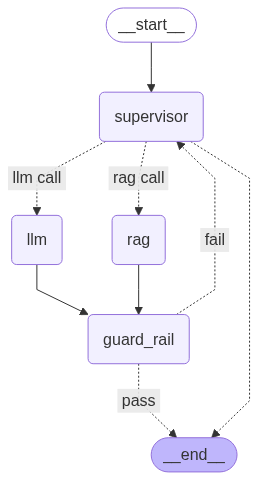

In [63]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [64]:
# run sample app
state={"messages":["can you tell me the industrial growth of world's most poor economy?"]}
result=app.invoke(state)


## supervisor ##
## supervisor ## question : can you tell me the industrial growth of world's most poor economy?
## supervisor ## response : topic='Not Related' reason_for_selection="The query is about the industrial growth of the world's poorest economy, which is not related to the USA."
## router ##
## router ## last_message : Not Related
## llm_call ##
## llm_call ## question : can you tell me the industrial growth of world's most poor economy?


> Entering new AgentExecutor chain...
I need to find information about the industrial growth of the world's poorest economy. First, I need to identify which country is considered the world's poorest economy. Then, I can search for information about its industrial growth.
Action: tavily_search_results_json
Action Input: "world's poorest economy"
Observation: [{'title': 'Poorest Countries in the World 2025 - World Population Review', 'url': 'https://worldpopulationreview.com/country-rankings/poorest-countries-in-the-world', 'content': '[Burun

KeyError: '__end__'